# Image Classification PyTorch 04

Dataset: https://www.kaggle.com/datasets/tongpython/cat-and-dog

The data is balance:
- Train 4000 cats and 4000 dogs
- Test 1000 cats and 1000 dogs

- Using 2 Conv2d (with more features / out_channels) and 2 Linear
- add Dropout

Import function

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
TRAIN_FOLDER = '~/data1/data/mlzoomcamp25/catdog/train'
TEST_FOLDER = '~/data1/data/mlzoomcamp25/catdog/test'

SEED = 42
BATCH_SIZE = 20
IMAGE_SIZE = 150
EPOCHS = 15

In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False



In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [6]:
train_dataset = datasets.ImageFolder(TRAIN_FOLDER, transform=train_transform)
test_dataset  = datasets.ImageFolder(TEST_FOLDER,  transform=test_val_transform)

# verify the number of classes
num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)


Classes: ['cats', 'dogs']


In [7]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=6, pin_memory=True, persistent_workers=True, prefetch_factor=4
                          )

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=6, pin_memory=True, persistent_workers=True, prefetch_factor=4
                         )


In [8]:
# create model
class CatDogModel(nn.Module):
    def __init__(self):
        super(CatDogModel, self).__init__()

        # Hout​=(Input+2Padding−Kernel​)/Stride+1
        self.base_model = nn.Sequential(
            # (150 + 2*0 - 3)/1 + 1 = 148
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=0), # (64, 148, 148)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (64, 74, 74)
            # (74 + 2*0 - 3)/1 + 1 = 72
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0), # (128, 72, 72)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # (128, 36, 36)
        )
        self.flatten = nn.Flatten() # (128, 36*36,) = 165888
        self.fc = nn.Sequential(
            nn.Linear(128 * 36 * 36, 1024), # (1024,)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 1), # (1,)
        )
               

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x 

In [9]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        labels = labels.float()
        if labels.ndim == 1:
            labels = labels.unsqueeze(1)  # Ensure shape [batch, 1]

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward() # compute gradients
        optimizer.step() # update weights

        total_loss += loss.item()

        preds = torch.sigmoid(outputs) > 0.5
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


In [10]:
def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            labels = labels.float()
            if labels.ndim == 1:
                labels = labels.unsqueeze(1)  # Ensure shape [batch, 1]

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(loader), accuracy


In [11]:

model = CatDogModel()
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1.0e-4)

Training loop

In [12]:

arr_train_acc = []
arr_train_loss = []

arr_test_acc = []
arr_test_loss = []

idx = 0
for epoch in range(EPOCHS):

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    test_loss, test_acc = validate(model, test_loader, criterion)

    arr_train_acc.append(train_acc)
    arr_train_loss.append(train_loss)
    arr_test_acc.append(test_acc)
    arr_test_loss.append(test_loss)

    print(idx)
    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val Loss  : {test_loss:.4f} | Val Acc: {test_acc:.4f}")

    idx += 1


0
Epoch 1/15
  Train Loss: 0.6898 | Train Acc: 0.5482
  Val Loss  : 0.6856 | Val Acc: 0.5907
1
Epoch 2/15
  Train Loss: 0.6825 | Train Acc: 0.5933
  Val Loss  : 0.6793 | Val Acc: 0.6322
2
Epoch 3/15
  Train Loss: 0.6772 | Train Acc: 0.6082
  Val Loss  : 0.6769 | Val Acc: 0.5779
3
Epoch 4/15
  Train Loss: 0.6724 | Train Acc: 0.6164
  Val Loss  : 0.6697 | Val Acc: 0.6347
4
Epoch 5/15
  Train Loss: 0.6675 | Train Acc: 0.6260
  Val Loss  : 0.6651 | Val Acc: 0.6396
5
Epoch 6/15
  Train Loss: 0.6628 | Train Acc: 0.6335
  Val Loss  : 0.6611 | Val Acc: 0.6431
6
Epoch 7/15
  Train Loss: 0.6586 | Train Acc: 0.6381
  Val Loss  : 0.6573 | Val Acc: 0.6485
7
Epoch 8/15
  Train Loss: 0.6545 | Train Acc: 0.6402
  Val Loss  : 0.6568 | Val Acc: 0.6303
8
Epoch 9/15
  Train Loss: 0.6508 | Train Acc: 0.6410
  Val Loss  : 0.6510 | Val Acc: 0.6476
9
Epoch 10/15
  Train Loss: 0.6469 | Train Acc: 0.6487
  Val Loss  : 0.6475 | Val Acc: 0.6480
10
Epoch 11/15
  Train Loss: 0.6435 | Train Acc: 0.6453
  Val Loss  :

Plot the result

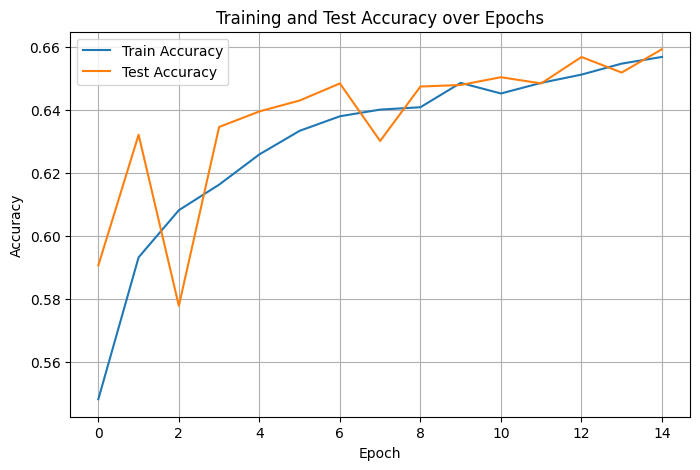

In [13]:

plt.figure(figsize=(8, 5))
plt.plot(arr_train_acc, label='Train Accuracy')
plt.plot(arr_test_acc, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.show()

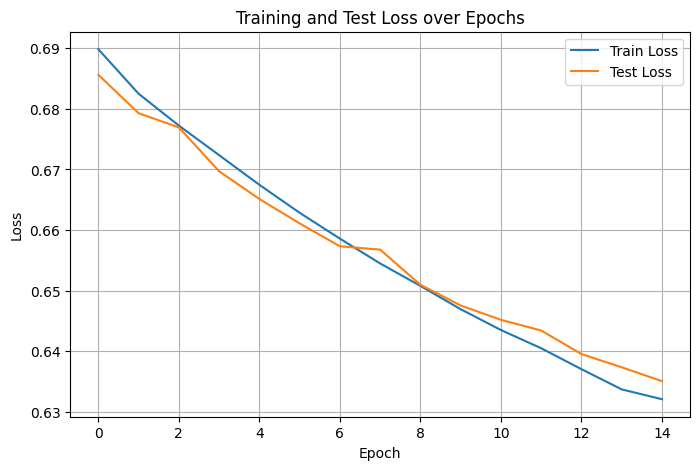

In [14]:

plt.figure(figsize=(8, 5))
plt.plot(arr_train_loss, label='Train Loss')
plt.plot(arr_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [15]:

df_train = pd.DataFrame({
    'train_loss': arr_train_loss,
    'train_accuracy': arr_train_acc
})
df_train

,train_loss,train_accuracy
0,0.689834,0.548157
1,0.682492,0.593254
2,0.677234,0.608245
3,0.672357,0.616365
4,0.667465,0.625984
5,0.662848,0.633479
6,0.658588,0.638101
7,0.654486,0.640225
8,0.650788,0.640974
9,0.646939,0.648720


In [16]:

df_test = pd.DataFrame({
    'val_loss': arr_test_loss,
    'val_accuracy': arr_test_acc
})
df_test

,val_loss,val_accuracy
0,0.685617,0.590707
1,0.679278,0.632229
2,0.676929,0.577855
3,0.669706,0.634701
4,0.665123,0.639644
5,0.661097,0.643104
6,0.657319,0.648542
7,0.656768,0.630252
8,0.650965,0.647553
9,0.647548,0.648047
